In [1]:
## Public Reaction to 23andMe’s Data Breach and Bankruptcy: A Social Sentiment Study
## By Arya Belhe

In [2]:
!pip install praw pandas

import praw
import pandas as pd
import time
from datetime import datetime

# ---------- 1) CONFIG: add your Reddit app credentials ----------
# Create a Reddit app at https://www.reddit.com/prefs/apps
REDDIT_CLIENT_ID = "YK4mpouZA7x5KDuFK-mWcQ"
REDDIT_CLIENT_SECRET = "mD4NXw7-whwQ0sfSYjAex66nts2Pjg"
REDDIT_USER_AGENT = "23andMe/0.1 by PrimaryNectarine2619"

# Files
OUTPUT_CSV = "reddit_reviews.csv"         # new reddit output
EXISTING_CSV = "existing_reviews.csv"     # your previous dataset (if present)
ALL_CSV = "all_reviews.csv"               # final combined file

# ---------- 2) Connect via PRAW ----------
reddit = praw.Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent=REDDIT_USER_AGENT,
)

# ---------- 3) Parameters for scraping ----------
# Option A: collect from a subreddit
SUBREDDIT = "23andme"   # or "ancestry", "genetics", etc.

# Option B (alternative): search site-wide for "23andMe" using reddit.subreddit("all").search()
SEARCH_QUERY = "23andMe OR \"23 and me\""

# How many posts / comments to fetch
MAX_SUBMISSIONS = 200      # submissions to iterate
MAX_COMMENTS_PER_SUB = 50  # comments collected from each submission (useful if parsing comments)

# Choose whether to collect top-level posts (title + selftext) and/or comments
COLLECT_POSTS = True
COLLECT_COMMENTS = True

# ---------- 4) Helper to normalize an entry into rating/review format ----------
def make_row_from_post(submission):
    # Combine title + selftext if present
    text = submission.title
    if getattr(submission, "selftext", ""):
        text = text + "\n\n" + submission.selftext
    return {
        "rating": submission.score,                # numeric upvote score as rating proxy
        "review": text,
        "source": "reddit_post",
        "id": submission.id,
        "created_utc": datetime.utcfromtimestamp(submission.created_utc)
    }

def make_row_from_comment(comment):
    return {
        "rating": comment.score,                  # comment score as rating proxy
        "review": comment.body,
        "source": "reddit_comment",
        "id": comment.id,
        "created_utc": datetime.utcfromtimestamp(comment.created_utc)
    }

# ---------- 5) Collect data ----------
rows = []

# a) Search posts matching query (site-wide)
print("Searching submissions...")
for i, submission in enumerate(reddit.subreddit("all").search(SEARCH_QUERY, limit=MAX_SUBMISSIONS)):
    try:
        if COLLECT_POSTS:
            rows.append(make_row_from_post(submission))

        if COLLECT_COMMENTS:
            submission.comments.replace_more(limit=0)
            count = 0
            for comment in submission.comments.list():
                if count >= MAX_COMMENTS_PER_SUB:
                    break
                rows.append(make_row_from_comment(comment))
                count += 1

        if (i+1) % 25 == 0:
            print(f"  processed {i+1} submissions...")
        time.sleep(0.5)  # be gentle
    except Exception as e:
        print("warning on submission", submission.id if 'submission' in locals() else "", e)
        continue

# b) Alternatively, collect from a specific subreddit (uncomment if preferred)
# for submission in reddit.subreddit(SUBREDDIT).hot(limit=MAX_SUBMISSIONS):
#     rows.append(make_row_from_post(submission))
#     submission.comments.replace_more(limit=0)
#     for comment in submission.comments.list()[:MAX_COMMENTS_PER_SUB]:
#         rows.append(make_row_from_comment(comment))

df_reddit = pd.DataFrame(rows)
print("Collected rows:", len(df_reddit))

# Keep only rating and review columns plus metadata
df_reddit = df_reddit[["id", "source", "rating", "review", "created_utc"]]

# Save new reddit CSV
df_reddit.to_csv(OUTPUT_CSV, index=False)
print(f"Saved reddit output to {OUTPUT_CSV}")


Searching submissions...


/tmp/ipykernel_571/2586248172.py:52: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "created_utc": datetime.utcfromtimestamp(submission.created_utc)
/tmp/ipykernel_571/2586248172.py:61: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "created_utc": datetime.utcfromtimestamp(comment.created_utc)


  processed 25 submissions...
  processed 50 submissions...
  processed 75 submissions...
  processed 100 submissions...
  processed 125 submissions...
  processed 150 submissions...
  processed 175 submissions...
  processed 200 submissions...
Collected rows: 4793
Saved reddit output to reddit_reviews.csv


In [3]:
import pandas as pd

# Load the CSV file
reddit_df = pd.read_csv("reddit_reviews.csv")

# View first 6 columns and first few rows
reddit_df.iloc[:, :6].head()
import re

# Drop missing reviews and clean text
reddit_df = reddit_df.dropna(subset=['review'])
reddit_df['clean_review'] = reddit_df['review'].str.lower()
reddit_df['clean_review'] = reddit_df['clean_review'].apply(
    lambda x: re.sub(r"http\S+|www\S+|[^a-z\s]", "", x)
)

reddit_df[['review', 'clean_review']].head()

,review,clean_review
0,OOP posts in 23andme: Are these really half si...,oop posts in andme are these really half sibli...
1,#Do not comment on the original posts\n\nPleas...,do not comment on the original posts\n\nplease...
2,Up to 1 in 20 people who take a DNA test exper...,up to in people who take a dna test experien...
3,My half sister and I were confirmed related vi...,my half sister and i were confirmed related vi...
4,A testament to the fact that your family is no...,a testament to the fact that your family is no...


In [11]:
!pip install nltk
!pip install TextBlob
import nltk
import re
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# -------------------------------
# 1. Load data
reddit_df = pd.read_csv("reddit_reviews.csv")

# -------------------------------
# 2. Basic text cleaning
# Drop rows without review text
reddit_df = reddit_df.dropna(subset=["review"])
reddit_df["clean_review"] = reddit_df["review"].str.lower()

# Remove URLs + non-alphabetic characters
reddit_df["clean_review"] = reddit_df["clean_review"].apply(
    lambda x: re.sub(r"http\S+|www\S+|[^a-z\s]", "", x)
)

# -------------------------------
# 3. Sentiment Analysis (VADER)
nltk.download("vader_lexicon")
# Initialize analyzer
sia = SentimentIntensityAnalyzer()
reddit_df["compound"] = reddit_df["clean_review"].apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

# Convert compound score → sentiment label
reddit_df["sentiment"] = reddit_df["compound"].apply(
    lambda x: "positive" if x > 0.05 else ("negative" if x < -0.05 else "neutral")
)

from textblob import TextBlob

# Create subjectivity column (0 = objective, 1 = subjective)
reddit_df['subjectivity'] = reddit_df['clean_review'].apply(
    lambda x: TextBlob(str(x)).sentiment.subjectivity
)
# -------------------------------
# 4. Save enhanced dataset
reddit_df.to_csv("reddit_reviews_enhanced.csv", index=False)
reddit_df[["clean_review", "compound", "sentiment"]].head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 29.9 MB/s eta 0:00:00


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,clean_review,compound,sentiment
0,oop posts in andme are these really half sibli...,0.9983,positive
1,do not comment on the original posts\n\nplease...,0.3182,positive
2,up to in people who take a dna test experien...,0.8201,positive
3,my half sister and i were confirmed related vi...,0.9217,positive
4,a testament to the fact that your family is no...,0.7783,positive


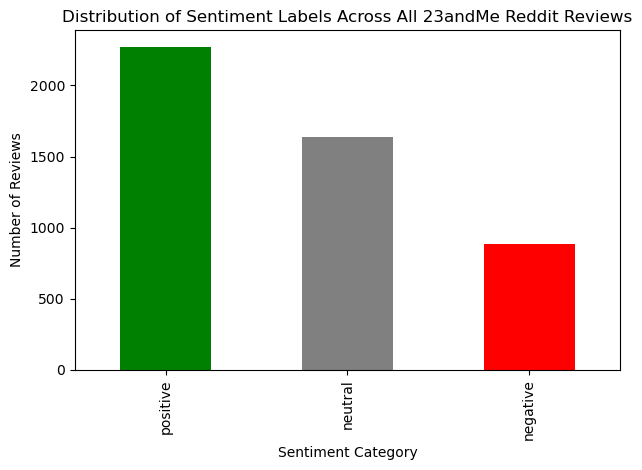

In [7]:
import matplotlib.pyplot as plt
# Plot count of sentiment labels (positive / neutral / negative)
reddit_df['sentiment'].value_counts().plot(
    kind='bar',
    color=['green', 'gray', 'red']
)

plt.title('Distribution of Sentiment Labels Across All 23andMe Reddit Reviews')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

/tmp/ipykernel_571/4111273921.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.Grouper(key='created_utc', freq='M')
/tmp/ipykernel_571/4111273921.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sentiment_time = sentiment_time.asfreq('M')


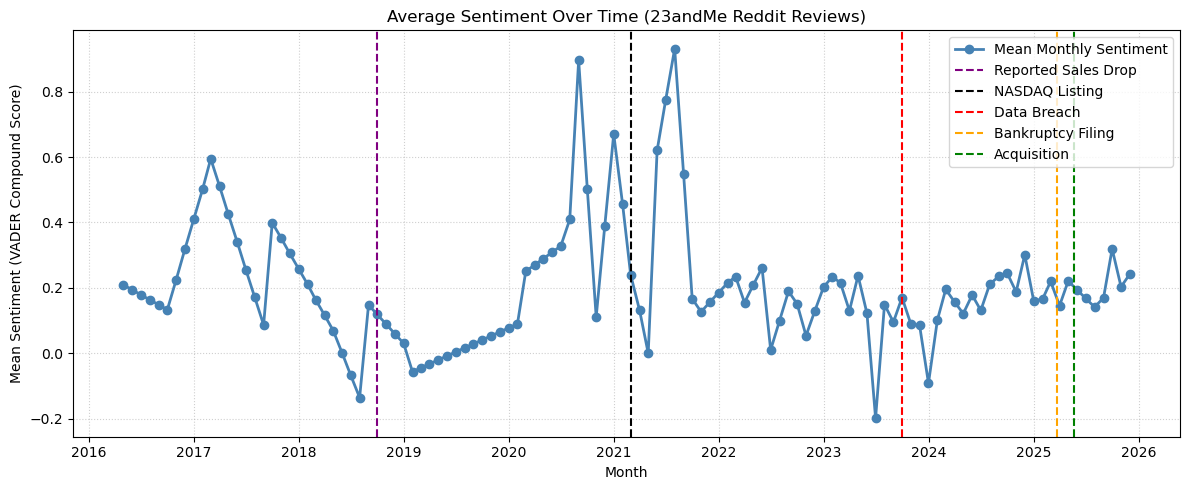

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# TIME-SERIES SENTIMENT PLOT
# ---------------------------------------------

# Ensure created_utc is a datetime object
reddit_df['created_utc'] = pd.to_datetime(reddit_df['created_utc'])


sentiment_time = reddit_df.groupby(
    pd.Grouper(key='created_utc', freq='M')
)['compound'].mean()

# Ensures plot continuity even if some months have zero posts
sentiment_time = sentiment_time.asfreq('M')
sentiment_time = sentiment_time.interpolate()
sentiment_time = sentiment_time.sort_index()

# Plot sentiment trend over time
plt.figure(figsize=(12, 5))
plt.plot(
    sentiment_time.index,
    sentiment_time.values,
    marker='o',
    color='steelblue',
    linewidth=2,
    label='Mean Monthly Sentiment'
)

# ---------------------------------------------
# EVENT MARKERS — key reputation-shifting events

plt.axvline(pd.Timestamp('2018-10-01'), color='purple', linestyle='--', linewidth=1.5, label='Reported Sales Drop')
plt.axvline(pd.Timestamp('2021-03-01'), color='black', linestyle='--', linewidth=1.5, label='NASDAQ Listing')
plt.axvline(pd.Timestamp('2023-10-01'), color='red', linestyle='--', linewidth=1.5, label='Data Breach')
plt.axvline(pd.Timestamp('2025-03-23'), color='orange', linestyle='--', linewidth=1.5, label='Bankruptcy Filing')
plt.axvline(pd.Timestamp('2025-05-19'), color='green', linestyle='--', linewidth=1.5, label='Acquisition')


# Formatting
plt.title('Average Sentiment Over Time (23andMe Reddit Reviews)')
plt.xlabel('Month')
plt.ylabel('Mean Sentiment (VADER Compound Score)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


/tmp/ipykernel_571/2834024060.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


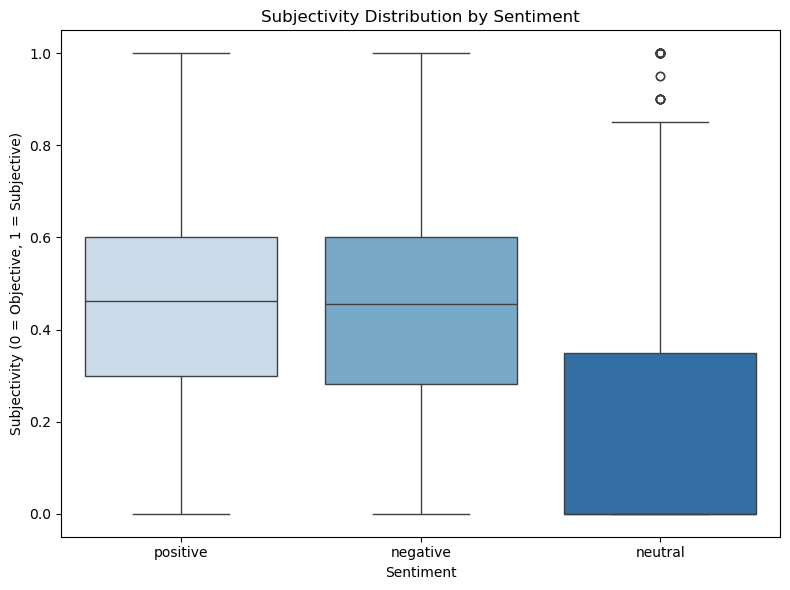

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# BOXPLOT: SUBJECTIVITY VS SENTIMENT

plt.figure(figsize=(8, 6))

sns.boxplot(
    x='sentiment',       # Group by sentiment category
    y='subjectivity',    # Plot the subjectivity scores
    data=reddit_df,      # Using your cleaned dataframe
    palette='Blues'      # (Optional) consistent color palette
)

plt.title('Subjectivity Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Subjectivity (0 = Objective, 1 = Subjective)')
plt.tight_layout()
plt.show()


In [ ]:
## Summary
## Positive and negative reviews contain similar levels of emotional/opinion-based language, 
## while neutral reviews are far more factual and objective.
## Negative reviews are equally emotional, not necessarily more subjective.
## Positive reviewers mix emotion + detail.

<Figure size 800x500 with 0 Axes>

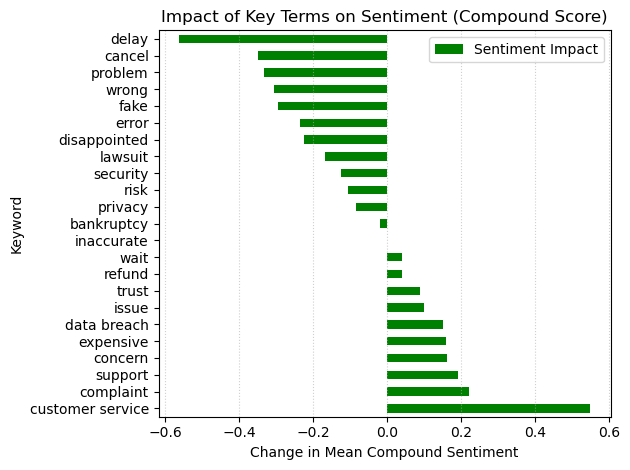

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------------------------------------
# 1. Choose key terms to measure sentiment impact
keywords = [
    'data breach', 'privacy', 'bankruptcy', 'expensive', 'wait', 'delay',
    'refund', 'cancel', 'issue', 'problem', 'error', 'wrong', 'concern',
    'complaint', 'support', 'customer service', 'security', 'risk',
    'lawsuit', 'dna leak', 'inaccurate', 'fake', 'trust', 'disappointed'
]

# Dictionary to store each keyword’s effect on sentiment
keyword_impact = {}

# ---------------------------------------------------------
# 2. Calculate sentiment difference for each keyword
for word in keywords:

    # mask = rows containing the keyword
    mask = reddit_df['clean_review'].str.contains(word, case=False, na=False)

    if mask.sum() > 0:
        # Mean sentiment when keyword is present
        mean_with = reddit_df.loc[mask, 'compound'].mean()

        mean_without = reddit_df.loc[~mask, 'compound'].mean()

        diff = mean_with - mean_without
        keyword_impact[word] = diff

# ---------------------------------------------------------
# 3. Convert results to DataFrame
impact_df = (
    pd.DataFrame.from_dict(keyword_impact, orient='index', columns=['Sentiment Impact'])
    .sort_values('Sentiment Impact', ascending=False)
)

# ---------------------------------------------------------
# 4. Plot the keyword sentiment impact
plt.figure(figsize=(8,5))
impact_df.plot(
    kind='barh',
    color=['green' if x > 0 else 'red' for x in impact_df['Sentiment Impact']]
)

plt.title('Impact of Key Terms on Sentiment (Compound Score)')
plt.xlabel('Change in Mean Compound Sentiment')
plt.ylabel('Keyword')
plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 24.0 MB/s eta 0:00:00


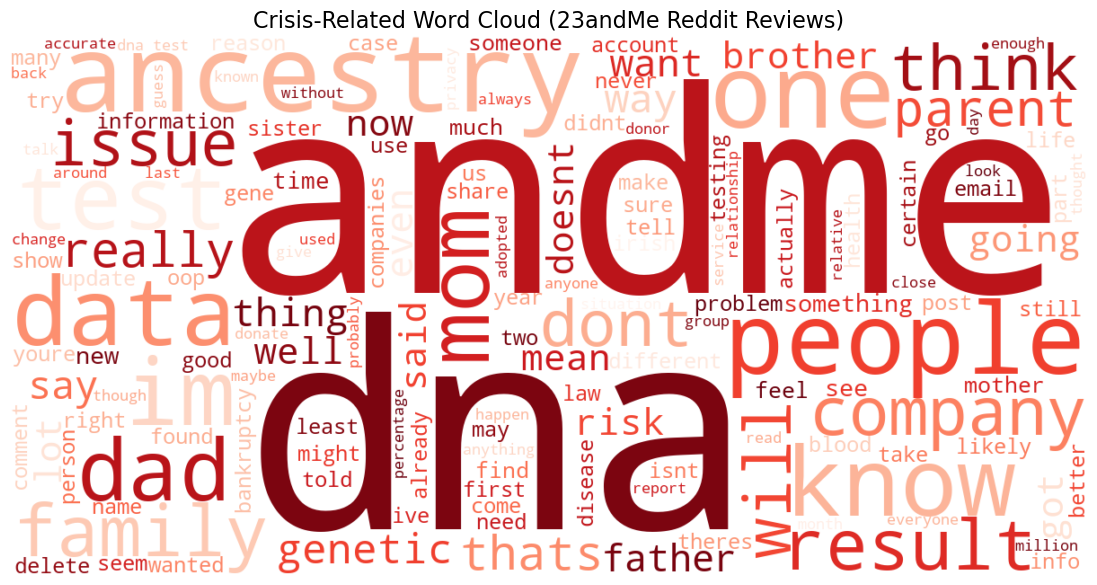

In [15]:
!pip install WordCloud
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Pick crisis-related terms you want to appear in the cloud
crisis_keywords = [
    "data breach", "breach", "privacy", "bankruptcy", "dna leak", 
    "leak", "lawsuit", "hack", "inaccurate", "fake", "refund", 
    "delay", "cancel", "problem", "issue", "security", "risk"
]

# Build a mask: reviews containing ANY of these words
mask = reddit_df['clean_review'].str.contains(
    "|".join(crisis_keywords), 
    case=False, na=False
)

# Subset only those reviews
crisis_reviews = reddit_df.loc[mask, 'clean_review']

# Combine text
text = " ".join(crisis_reviews)

# Create the word cloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    colormap='Reds',          # red theme for crisis
    max_words=150
).generate(text)

# Plot
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Crisis-Related Word Cloud (23andMe Reddit Reviews)", fontsize=16)
plt.show()


In [25]:
!pip install squarify
import pandas as pd
import squarify
import matplotlib.pyplot as plt

# Complaint trigger keywords
complaint_categories = {
    "Privacy": ["privacy", "data", "breach", "dna leak", "security", "risk"],
    "Price": ["expensive", "price", "cost", "overpriced", "refund"],
    "Accuracy": ["inaccurate", "wrong", "error", "fake", "incorrect"],
    "Customer Support": ["support", "customer service", "help", "agent", "response"],
    "Waiting Time": ["wait", "delay", "slow", "time", "processing"]
}
def map_complaints(text):
    found = []
    for category, keywords in complaint_categories.items():
        if any(k in text for k in keywords):
            found.append(category)
    return found

reddit_df["complaints"] = reddit_df["clean_review"].apply(map_complaints)


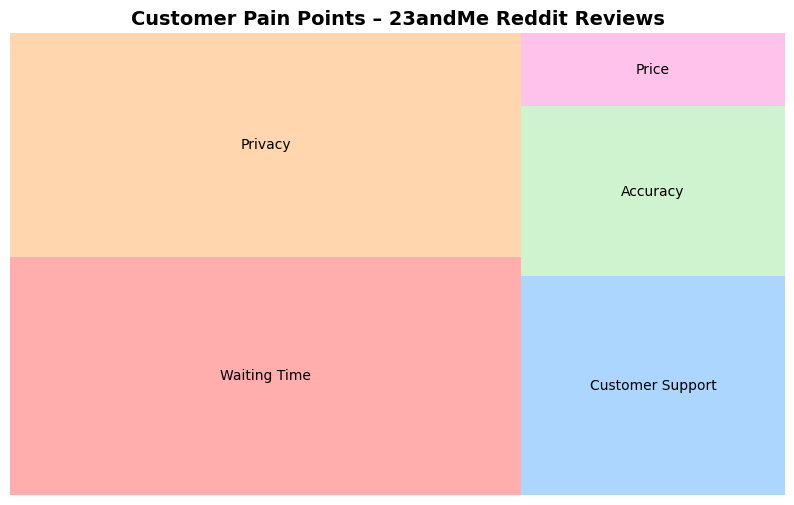

In [26]:
from itertools import chain
# Flatten the list of lists of complaints into a single list
all_complaints = list(chain.from_iterable(reddit_df["complaints"]))
# Count the frequency of each complaint category
complaint_counts = pd.Series(all_complaints).value_counts()
complaint_counts

plt.figure(figsize=(10,6))
squarify.plot(
    sizes=complaint_counts.values,
    label=complaint_counts.index,
    alpha=0.8,
    color=["#ff9999","#ffcc99","#99ccff","#c2f0c2","#ffb3e6"]
)
plt.title("Customer Pain Points – 23andMe Reddit Reviews", fontsize=14, weight="bold")
plt.axis("off")
plt.show()
